In [1]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score , mean_squared_error, r2_score

from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import psycopg2

from config import password

In [2]:
# Load the pga data set dataset from database 
connection_string = f"host=red-team-final.c3yshvuxvm9x.us-east-2.rds.amazonaws.com dbname=red-team port=5432 user=postgres password={password}"
connection = psycopg2.connect(connection_string)

In [3]:
# Establish connection and db
sql = "select * from pga_stats"
pga_df = pd.read_sql(sql, connection)

In [4]:
# Show df
pga_df = pga_df.rename(columns={"money_MONEY":"Winnings"})
pga_df

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO,Winnings
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84,5443091
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79,3556232
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48,1782342
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91,1482028
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15,164271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,-0.063,0.284,300.9,63.32,16.67,0.585,66.43,73.44,76.26,54.23,...,56.10,58.99,-0.113,36.55,3.22,1.807,29.45,16.26,1.17,824162
461,-0.417,-0.168,278.7,60.89,1.92,-0.006,63.53,68.20,73.63,48.14,...,54.17,62.30,0.451,42.02,1.42,1.748,28.32,15.03,1.27,942372
462,0.022,-0.402,285.1,62.05,1.69,-0.429,64.69,69.61,77.00,52.37,...,51.35,58.67,-0.006,38.51,2.73,1.779,29.15,16.95,1.14,332352
463,0.255,0.325,296.4,63.35,13.27,0.251,66.07,71.07,76.71,51.13,...,51.45,56.98,0.154,38.78,3.05,1.772,29.08,17.05,1.24,1943309


In [5]:
# Define the features and exclude winnings 
X = pga_df.drop(columns=["Winnings", "bogey_avoid_% MAKES BOGEY", "btb_ratio_BIRDIE TO BOGEY RATIO", "SG_tee_green_AVERAGE", "GIR_pct_%", "GIR_pct_fwy_%", "GIR_pct_not_fwy_%", "GOFIR_pct_%", "pct_three_putt_avoid_%", "pct_one_putt_%", "scrambling_%", "driving_320+_%", "pct_sand_save_%"], axis=1)

In [6]:
# Define the target set as Money/ Earning PGA
y = pga_df[["Winnings"]]
y.head()

,Winnings
0,5443091
1,3556232
2,1782342
3,1482028
4,164271


In [7]:
# Prep data for ML model
# Labels = values we want to predict
y = np.array(pga_df["Winnings"])

# Save list to use later
feature_list = list(X.columns)

# Convert to numpy array
X = np.array(X)

In [8]:
# Split Data into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("--------------------------")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("--------------------------")
print("y_train mean:", round(np.mean(y_train),2))
print("--------------------------")
print("y_test mean:", round(np.mean(y_test),2))
print("--------------------------")

--------------------------
X_train shape: (325, 10)
X_test shape: (140, 10)
--------------------------
y_train mean: 2139972.29
--------------------------
y_test mean: 1827265.64
--------------------------


In [9]:
# Create a scaler instance
scaler = StandardScaler()

# Fit
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# ML model
# Define model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define variables for grid
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

grid=dict()
grid['alpha'] = alphas
grid['l1_ratio'] = ratios

# Define and perform search
# search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Fit
# results = search.fit(X_train, y_train)

# Define and fit model
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
model.fit(X_train_scaled, y_train)

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453230144947844.5, tolerance: 91876349719.05168
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 485818131592461.7, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189884203116595.62, tolerance: 96340475747.00829
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164986376600163.06, tolerance: 82486824666.08713
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932685.38, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756589.38, tolerance: 98006640628.00241
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932684.25, tolerance: 97577030069.62761
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196176613867523.62, tolerance: 101474222287.22984
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194945102403873.38, tolerance: 96905545901.18408
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932684.75, tolerance: 97577030069.62761
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756589.75, tolerance: 98006640628.00241
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202124959778616.88, tolerance: 102875477373.40135
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198626162597255.0, tolerance: 96513690262.15688
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756588.0, tolerance: 98006640628.00241
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189884203116594.38, tolerance: 96340475747.00829
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191961489679330.5, tolerance:

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191581074214209.5, tolerance: 100715935825.23448
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183708253067192.62, tolerance: 96841985665.16643
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.75, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196176613867522.88, tolerance: 101474222287.22984
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182721157836839.94, tolerance: 87860576598.0503
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results 

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176438881081446.75, tolerance: 82638362891.74165
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196176613867524.0, tolerance: 101474222287.22984
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932684.38, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198206469676937.0, tolerance: 99764391071.93922
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194945102403873.5, tolerance: 96905545901.18408
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164986376600163.12, tolerance: 82486824666.08713
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198626162597254.75, tolerance: 96513690262.15688
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results 

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202124959778616.12, tolerance: 102875477373.40135
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191152895750290.62, toleranc

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178888973243644.25, tolerance: 96570891976.40353
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191581074214208.62, tolerance: 100715935825.23448
  tol, rng, random, positive)
C:\Users\joela\a

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932684.25, tolerance: 97577030069.62761
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756588.25, tolerance: 98006640628.00241
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202124959778616.5, tolerance:

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198752289644553.12, tolerance: 101084593512.0085
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196484857137578.38, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189343433996151.25, tolerance: 95669122535.58301
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756588.38, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.88, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177831743017453.75, tolerance: 93609579352.90298
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.25, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191961489679331.38, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201282032139879.75, tolerance: 102357508588.1769
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672167.75, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191961489679330.75, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188125386149102.12, tolerance: 94587457565.09346
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188125386149101.75, tolerance: 94587457565.09346
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191581074214209.38, tolerance: 100715935825.23448
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194945102403872.88, tolerance: 96905545901.18408
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932683.75, tolerance: 97577030069.62761
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202124959778615.88, tolerance: 102875477373.40135
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191152895750291.12, tolerance: 101586155699.36665
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected result

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178888973243643.5, tolerance: 96570891976.40353
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201282032139879.62, tolerance: 102357508588.1769
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177831743017453.25, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185773606653306.5, tolerance: 96202388663.95848
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201282032139880.0, tolerance: 102357508588.1769
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185773606653307.12, tolerance: 96202388663.95848
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672170.0, tolerance:

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191756497404503.2, tolerance: 91876349719.05168
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191152895750290.62, tolerance: 101586155699.36665
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\a

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201282032139880.0, tolerance: 102357508588.1769
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177831743017453.12, tolerance:

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.75, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195067302053151.38, tolerance: 99895374002.30634
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results 

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191756497404503.94, tolerance: 91876349719.05168
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191581074214208.25, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185773606653306.5, tolerance: 96202388663.95848
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.25, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results a

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191581074214207.88, tolerance: 100715935825.23448
  tol, rng, random, positive)
C:\Users\joela\a

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.75, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932685.0, tolerance: 97577030069.62761
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194945102403873.12, tolerance: 96905545901.18408
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164986376600163.12, tolerance: 82486824666.08713
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932684.12, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189343433996150.75, tolerance: 95669122535.58301
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756588.5, tolerance:

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191961489679331.0, tolerance: 101521878195.39738
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordina

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194945102403873.0, tolerance: 96905545901.18408
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194945102403873.5, tolerance: 96905545901.18408
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178888973243644.0, tolerance: 96570891976.40353
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196484857137578.12, tolerance: 96202466795.17523
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results a

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201282032139879.38, tolerance: 102357508588.1769
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177831743017453.5, tolerance: 93609579352.90298
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results a

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183708253067193.75, tolerance: 96841985665.16643
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196484857137577.75, tolerance: 96202466795.17523
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164986376600163.12, tolerance

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201282032139879.88, tolerance: 102357508588.1769
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189343433996151.5, tolerance: 95669122535.58301
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191152895750290.75, tolerance:

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202124959778616.5, tolerance: 102875477373.40135
  tol, rng, random, positive)
C:\Users\joela\an

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185773606653306.38, tolerance: 96202388663.95848
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189997593672169.38, tolerance: 98618726458.39017
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results 

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178986930932684.38, tolerance: 97577030069.62761
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191756497404502.62, tolerance: 91876349719.05168
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results 

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202124959778616.0, tolerance: 102875477373.40135
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191152895750291.5, tolerance: 101586155699.36665
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results 

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196484857137577.5, tolerance: 96202466795.17523
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\ana

C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199683095364933.75, tolerance: 102403919846.45029
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186309984756588.5, tolerance

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1)

In [11]:
# Summarize
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.100000
l1_ratio_: 0.430000


In [12]:
# Predict
y_pred = model.predict(X_test_scaled)

In [13]:
# Evaluate performance
# MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {round(mse,2)}')

rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse,2)}')

# Coefficient of Determination (should match explained variance)
print(f'Coefficient of Determination: {round(r2_score(y_test, y_pred),2)}')

# Calculate the absolute errors
error = abs(y_pred - y_test)

# Print mean absolute error
print(f'Mean Absolute Error: {round(np.mean(error),2)}')

Mean squared error: 889304217228.79
RMSE: 943029.28
Coefficient of Determination: 0.6
Mean Absolute Error: 720243.78


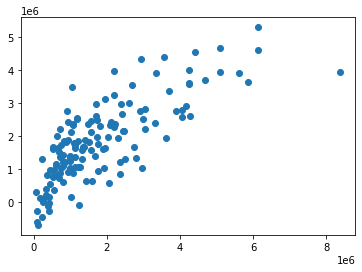

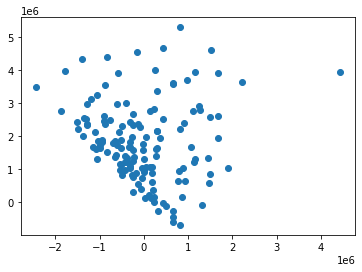

In [17]:
# Plot predicted vs true and residuals vs predicted
residuals = y_test - y_pred
plt.scatter(y_test,y_pred)
plt.show()

residuals = y_test - y_pred
plt.scatter(residuals,y_pred)
plt.show()

10 features, reduction of 0.00%


<AxesSubplot:>

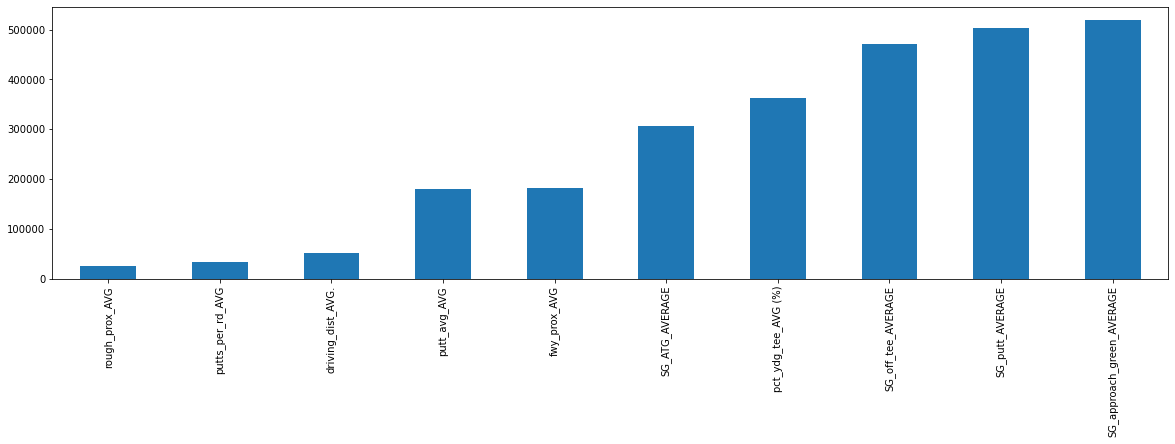

In [16]:
# Define columns list
columns_list = pga_df.drop(columns=["Winnings", "bogey_avoid_% MAKES BOGEY", "btb_ratio_BIRDIE TO BOGEY RATIO", "SG_tee_green_AVERAGE", "GIR_pct_%", "GIR_pct_fwy_%", "GIR_pct_not_fwy_%", "GOFIR_pct_%", "pct_three_putt_avoid_%", "pct_one_putt_%", "scrambling_%", "driving_320+_%", "pct_sand_save_%"], axis=1)

# Create series for plot
feature_importance = pd.Series(index = columns_list.columns, data = np.abs(model.coef_))

# Print selected
n_selected_features = (feature_importance > 0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,(1-n_selected_features/len(feature_importance))*100))

# Sort and define kind and size
feature_importance.sort_values().tail(25).plot(kind = 'bar', figsize = (20,5))